# Imports Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Loading Datasets

In [2]:
# Laading datasets train and test

def date_parser(date_str):
    return pd.to_datetime(date_str, format='%Y-%m-%d')

train_df = pd.read_csv("../demand-forecasting-kernels-only/train.csv",parse_dates=['date'], date_parser=date_parser)
test_df = pd.read_csv("../demand-forecasting-kernels-only/test.csv", index_col= 0,parse_dates=['date'], date_parser=date_parser)

In [3]:
print(train_df.shape)
train_df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
print(test_df.shape)
test_df.head()

(45000, 3)


,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


In [5]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store             int64
item              int64
dtype: object


In [6]:
# changing dtypes of date and sales

train_df = train_df.astype({"sales": "float64", "store": "category", "item": "category"})
test_df = test_df.astype({"store": "category", "item": "category"})

In [7]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store          category
item           category
sales           float64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store          category
item           category
dtype: object


# Feature Enginering

In [8]:
def createAdditionalFeatures(df):

        df = df.copy()
        df["day"] = df.index.dayofweek
        df["quarter"] = df.index.quarter
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        df['weekofyear'] = df.index.isocalendar().week

        for lag in [91, 126, 364, 728, 1092]:
                df[f"lag_{lag}"] = df.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag))

        return df

In [9]:
def convertToCategory(df):
    cols = ["day","quarter", "year", "month", "dayofyear", "dayofmonth", "weekofyear"]

    for col in cols:
        df = df.astype({col: "category"})

    return df

In [10]:
training_df = train_df.set_index("date")
training_df = createAdditionalFeatures(training_df)
training_df = convertToCategory(training_df)
print(training_df.shape)
training_df.tail()

(913000, 15)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,lag_126,lag_364,lag_728,lag_1092
date,,,,,,,,,,,,,,,
2017-12-27,10,50,63.0,2,4,2017,12,361,27,52,80.0,104.0,43.0,51.0,40.0
2017-12-28,10,50,59.0,3,4,2017,12,362,28,52,82.0,89.0,68.0,44.0,46.0
2017-12-29,10,50,74.0,4,4,2017,12,363,29,52,90.0,98.0,63.0,59.0,53.0
2017-12-30,10,50,62.0,5,4,2017,12,364,30,52,103.0,92.0,64.0,63.0,61.0
2017-12-31,10,50,82.0,6,4,2017,12,365,31,52,99.0,116.0,69.0,81.0,57.0


# Model Building

In [11]:
def outputScalar(df):
    sales = df["sales"]
    non_category_data = df.drop(columns=["sales"]).select_dtypes(exclude=['category']).values
    columns = df.drop(columns=["sales"]).select_dtypes(exclude=['category']).columns
    index = df.select_dtypes(exclude=['category']).index

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(non_category_data)
    scaled_df = pd.DataFrame(scaled_data, columns= columns)
    scaled_df = scaled_df.set_index(index)

    final_df = pd.concat([scaled_df, sales], axis = 1)

    category_df = df.select_dtypes(include=['category'])
    encoded_categorical_df = category_df.astype(float)

    final_df = pd.concat([final_df, encoded_categorical_df], axis = 1)
    
    return final_df


In [12]:
scaled_df = outputScalar(training_df)
scaled_df = scaled_df.fillna(0)

In [13]:
model = Sequential()
model.add(LSTM(64, activation= 'relu', input_shape=(scaled_df.shape[1]-1, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Deep Learning Cross Validation

In [15]:
tss = TimeSeriesSplit(n_splits= 5, test_size= 24*365*10, gap= 24)
scaled_df = scaled_df.sort_index()

preds = []
scores = []

features = [col for col in scaled_df.columns if col not in ["sales"]]
target = "sales"


for index, (train_id, val_id) in enumerate(tss.split(scaled_df)):

    train = scaled_df.iloc[train_id]
    val = scaled_df.iloc[val_id]

    X_train = train[features]
    y_train = train[target]

    X_test = val[features]
    y_test = val[target]

    print(f"============================Fold {index}================================")
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop])
    
    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print("\n")

============================Fold 0================================
Epoch 1/5
11875/11875 [==============================] - 160s 13ms/step - loss: 284.9208 - val_loss: 120.6801
Epoch 2/5
11875/11875 [==============================] - 172s 14ms/step - loss: 141.9264 - val_loss: 92.7947
Epoch 3/5
11875/11875 [==============================] - 182s 15ms/step - loss: 110.9492 - val_loss: 79.9865
Epoch 4/5
11875/11875 [==============================] - 157s 13ms/step - loss: 104.5921 - val_loss: 78.0411
Epoch 5/5
2738/2738 [==============================] - 13s 4ms/step


============================Fold 1================================
Epoch 1/5
14065/14065 [==============================] - 195s 14ms/step - loss: 98.1692 - val_loss: 77.7493
Epoch 2/5
14065/14065 [==============================] - 181s 13ms/step - loss: 96.0538 - val_loss: 77.4170
Epoch 3/5
14065/14065 [==============================] - 194s 14ms/step - loss: 94.5433 - val_loss: 70.3002
Epoch 4/5
14065/14065 [============

In [16]:
print(f"Fold Scores: {scores}")
print(f"Average Score: {np.mean(scores):0.2f}")

Fold Scores: [8.219247769606769, 10.765228031762534, 11.018401856123015, 12.988050051192632, 11.866742504345053]
Average Score: 10.97


# Retraining XGBoost Model and Predict the Future

In [17]:
# Retrain using all data for predicting future 
X_all = scaled_df[features]
y_all = scaled_df[target]

history = model.fit(X_all, y_all, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/5
22825/22825 [==============================] - 652s 29ms/step - loss: 157.8875 - val_loss: 108.9853
Epoch 2/5
22825/22825 [==============================] - 345s 15ms/step - loss: 160.0927 - val_loss: 101.2895
Epoch 3/5
22825/22825 [==============================] - 476s 21ms/step - loss: 151.5521 - val_loss: 92.4363
Epoch 4/5
22825/22825 [==============================] - 415s 18ms/step - loss: 153.6496 - val_loss: 102.1274
Epoch 5/5
22825/22825 [==============================] - 382s 17ms/step - loss: 143.0724 - val_loss: 99.6345


In [18]:
test_df = test_df.set_index("date")
df = pd.concat([training_df, test_df])
df = createAdditionalFeatures(df)
df = convertToCategory(df)
print(df.shape)
df.tail()

(958000, 15)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,lag_126,lag_364,lag_728,lag_1092
date,,,,,,,,,,,,,,,
2018-03-27,10,50,NaN,1,1,2018,3,86,27,13,41.0,81.0,60.0,73.0,61.0
2018-03-28,10,50,NaN,2,1,2018,3,87,28,13,63.0,81.0,73.0,68.0,61.0
2018-03-29,10,50,NaN,3,1,2018,3,88,29,13,59.0,87.0,68.0,75.0,77.0
2018-03-30,10,50,NaN,4,1,2018,3,89,30,13,74.0,81.0,69.0,83.0,79.0
2018-03-31,10,50,NaN,5,1,2018,3,90,31,13,62.0,78.0,101.0,82.0,81.0


In [19]:
scaled_df = outputScalar(df)
scaled_df.tail()

,lag_91,lag_126,lag_364,lag_728,lag_1092,sales,store,item,day,quarter,year,month,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,,,,
2018-03-27,0.177489,0.350649,0.280374,0.372449,0.322751,NaN,10.0,50.0,1.0,1.0,2018.0,3.0,86.0,27.0,13.0
2018-03-28,0.272727,0.350649,0.341121,0.346939,0.322751,NaN,10.0,50.0,2.0,1.0,2018.0,3.0,87.0,28.0,13.0
2018-03-29,0.255411,0.376623,0.317757,0.382653,0.407407,NaN,10.0,50.0,3.0,1.0,2018.0,3.0,88.0,29.0,13.0
2018-03-30,0.320346,0.350649,0.322430,0.423469,0.417989,NaN,10.0,50.0,4.0,1.0,2018.0,3.0,89.0,30.0,13.0
2018-03-31,0.268398,0.337662,0.471963,0.418367,0.428571,NaN,10.0,50.0,5.0,1.0,2018.0,3.0,90.0,31.0,13.0


In [20]:
future_df = scaled_df.loc[scaled_df.sales.isna()].copy()
future_df["pred"] = model.predict(future_df[features])
print(future_df.shape)
future_df.head()

1407/1407 [==============================] - 10s 7ms/step
(45000, 16)


,lag_91,lag_126,lag_364,lag_728,lag_1092,sales,store,item,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,pred
date,,,,,,,,,,,,,,,,
2018-01-01,0.051948,0.064935,0.070093,0.061224,0.074074,NaN,1.0,1.0,0.0,1.0,2018.0,1.0,1.0,1.0,1.0,15.604528
2018-01-02,0.077922,0.090909,0.046729,0.061224,0.047619,NaN,1.0,1.0,1.0,1.0,2018.0,1.0,2.0,2.0,1.0,14.051098
2018-01-03,0.064935,0.095238,0.074766,0.081633,0.068783,NaN,1.0,1.0,2.0,1.0,2018.0,1.0,3.0,3.0,1.0,18.129013
2018-01-04,0.086580,0.112554,0.065421,0.061224,0.095238,NaN,1.0,1.0,3.0,1.0,2018.0,1.0,4.0,4.0,1.0,16.772282
2018-01-05,0.082251,0.164502,0.112150,0.061224,0.095238,NaN,1.0,1.0,4.0,1.0,2018.0,1.0,5.0,5.0,1.0,20.072422


# Forecasting Total Sales

In [21]:
pred_total_sales_df = future_df.reset_index()[["date","pred"]].set_index("date").rename(columns= {"pred":"sales"})

year_month = pred_total_sales_df.index.to_period("M")

pred_total_sales_df = pred_total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
print(pred_total_sales_df.shape)
pred_total_sales_df.head()

(3, 7)


sales                                                          \
         count          sum       mean     median        std       min   
date                                                                     
2018-01  15500  703199.0000  45.367676  41.947510  22.238763  8.987080   
2018-02  14000  703079.6250  50.219975  46.464767  24.867874  9.904591   
2018-03  15500  915818.6875  59.085075  56.121384  29.425344  9.420849   

                     
                max  
date                 
2018-01  125.554962  
2018-02  137.188019  
2018-03  147.040207

In [22]:
total_sales_df = train_df.drop(columns = ["store", "item"]).set_index("date")

year_month = total_sales_df.index.to_period("M")
total_sales_df = total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
total_sales_df = pd.concat([total_sales_df,pred_total_sales_df])
total_sales_df.drop(total_sales_df.tail(2).index,
                    inplace = True)
print(total_sales_df.shape)
total_sales_df.head()

(61, 7)


sales                                                   
         count       sum       mean median        std  min    max
date                                                             
2013-01  15500  454904.0  29.348645   27.0  15.087507  2.0   97.0
2013-02  14000  459417.0  32.815500   30.0  16.824119  2.0  103.0
2013-03  15500  617382.0  39.831097   37.0  20.167826  3.0  122.0
2013-04  15000  682274.0  45.484933   42.0  22.898429  3.0  138.0
2013-05  15500  763242.0  49.241419   46.0  24.630070  3.0  156.0

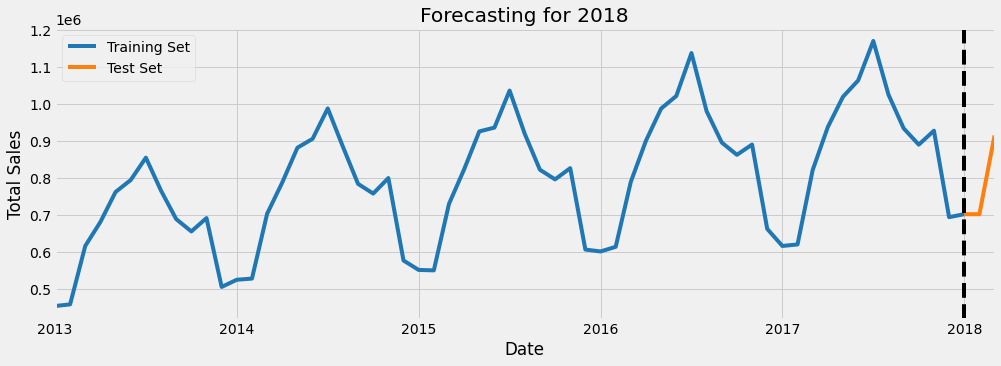

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
total_sales_df[("sales","sum")].plot(ax= ax,
                    label= "Training Set",
                    title= "Forecasting for 2018", 
                    color= color_pal[0],)
pred_total_sales_df[("sales","sum")].plot(ax= ax,
                    label= "Test Set",
                    color= color_pal[1])
ax.axvline(pred_total_sales_df.index.min(), color= "black", ls= "--")
ax.set(xlabel='Date', ylabel='Total Sales')
ax.legend(["Training Set","Test Set",])
plt.show()

# Predicted 2018 Daily Sales

In [24]:
daily_df = future_df.groupby(["date"]).agg({"pred": ["count","sum", "mean", "median", "std", "min", "max"]})
print(daily_df.shape)
daily_df.head()

(90, 7)


pred                                                            \
           count           sum       mean     median        std        min   
date                                                                         
2018-01-01   500  18309.123047  36.618248  35.027496  16.876075   9.763783   
2018-01-02   500  21424.132812  42.848267  40.373043  20.032453  10.022472   
2018-01-03   500  21289.533203  42.579067  40.089012  19.770361  10.212727   
2018-01-04   500  22851.833984  45.703667  43.081398  21.659597  11.568211   
2018-01-05   500  23985.892578  47.971786  45.693596  22.640797  12.114864   

                        
                   max  
date                    
2018-01-01   81.471405  
2018-01-02   99.327271  
2018-01-03   94.515594  
2018-01-04  110.397156  
2018-01-05  108.191803

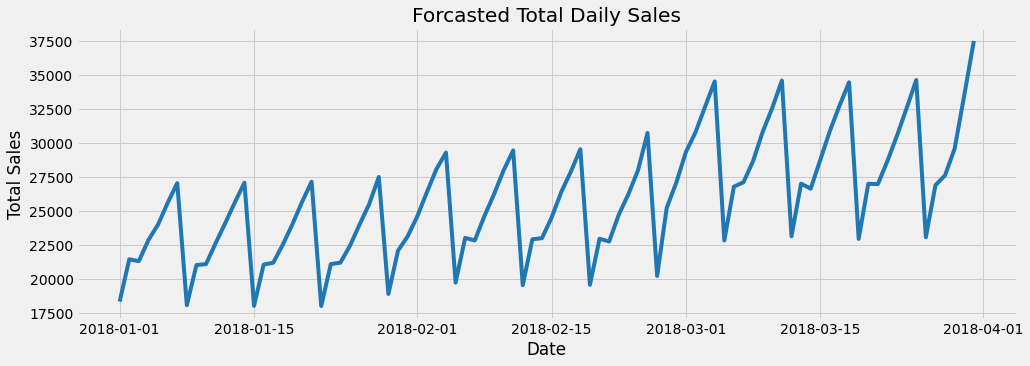

In [25]:
# Daily sales in 2018 for all stores
plt.figure(figsize=(15,5))

ax = sns.lineplot(data= daily_df,x='date',y=('pred','sum'),color= color_pal[0])
ax.set(xlabel='Date', ylabel='Total Sales', title='Forcasted Total Daily Sales')
plt.show()

## Output to CSV

In [26]:
output_df = pd.DataFrame(future_df["pred"]).rename(columns={"pred":"sales"}).reset_index(drop=True).rename_axis('id', axis=1)
print(output_df.shape)
output_df.head()

(45000, 1)


id,sales
0,15.604528
1,14.051098
2,18.129013
3,16.772282
4,20.072422


In [27]:
output_df.to_csv("../results/deeplearning_submission.csv", index=True, index_label= "id")